In [2]:
# papermill parameters
zona = 31
class_label="Class_label_Cuartiles"
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


### IMPORTA LAS LIBRERÍAS

In [3]:
try:
    import lightgbm
    print("✅ lightgbm ya está instalado")
except ImportError:
    !pip install lightgbm


✅ lightgbm ya está instalado


In [4]:
try:
    import shap
    print("✅ shap ya está instalado")
except ImportError:
    !pip install shap


✅ shap ya está instalado


In [5]:

try:
    import optuna
    print("✅ optuna ya está instalado")
except ImportError:
    !pip install optuna

✅ optuna ya está instalado


In [6]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import lightgbm as lgb
import shap

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import seaborn as sns

import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

import json




### LECTURA DE DATAFRAME DE ENTRADA

In [7]:

# Leer el DataFrame de entrada

filename = f"Dataframe_caracteristicas_entrada_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df = pd.read_pickle(output_file)

df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Columns: 116 entries, FechaHora to Ccluster
dtypes: Int64(1), datetime64[ns](1), float64(110), geometry(1), object(3)
memory usage: 1.7+ MB


### AÑADIR COLUMNAS CON FECHA

In [8]:
# -------------------------
# 1. Características de fecha/hora (codificación cíclica)
# -------------------------
datetime_col = 'FechaHora'  
if datetime_col in df.columns:
    df["year"] = df[datetime_col].dt.year
    df["month"] = df[datetime_col].dt.month
    df["day"] = df[datetime_col].dt.day
    df["hour"] = df[datetime_col].dt.hour
    df["dayofweek"] = df[datetime_col].dt.dayofweek

    # codificación cíclica
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    # Eliminamos columnas originales de fecha si no las queremos como enteros
    #df = df.drop(columns=[datetime_col, "month", "hour", "dayofweek"]) 

print("Shape tras añadir datetime features:", df.shape)

Shape tras añadir datetime features: (1930, 127)


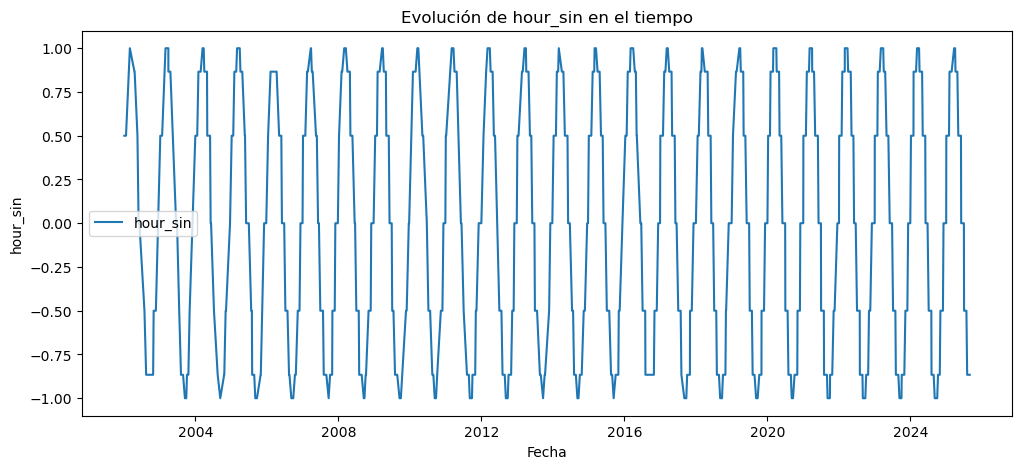

In [9]:

plt.figure(figsize=(12,5))
plt.plot(df['FechaHora'], df['month_sin'], label="hour_sin")
plt.xlabel("Fecha")
plt.ylabel("hour_sin")
plt.title("Evolución de hour_sin en el tiempo")
plt.legend()
plt.show()

### VECTOR DE ENTRADA: X
#### Dejar solo columnas numéricas

In [10]:
# Eliminamos columnas originales que no contienen información numérica
# Se define el vector de entrada

X = df.drop(columns=[datetime_col, 
                      "Evento",
                      "Latitud",
                      "Longitud",
                      "Inten",
                      "Mag",
                      "Tipo_Mag",
                      "Localizacion",
                      "FechaHora",
                      "geometry",
                      "Zona_ID",
                      "month", 
                      "day",
                      "hour", 
                      "dayofweek"]) 

### LECTURA DE DATAFRAME DE SALIDA

In [11]:

# Leer el DataFrame de salida

filename = f"Datos_salida_clases_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df_out = pd.read_pickle(output_file)

df_out.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Evento                 1930 non-null   object        
 1   Latitud                1930 non-null   float64       
 2   Longitud               1930 non-null   float64       
 3   Prof_Km                1930 non-null   float64       
 4   Inten                  1930 non-null   object        
 5   Mag                    1930 non-null   float64       
 6   Tipo_Mag               1930 non-null   Int64         
 7   Localizacion           1930 non-null   object        
 8   FechaHora              1930 non-null   datetime64[ns]
 9   Mag_mbLgL              1930 non-null   float64       
 10  geometry               1930 non-null   geometry      
 11  Zona_ID                1930 non-null   float64       
 12  Mmax_next30d           1930 non-null   float64       


### VECTOR DE SALIDA: y

In [12]:
y = df_out[class_label]
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1930 entries, 0 to 1929
Series name: Class_label_Cuartiles
Non-Null Count  Dtype
--------------  -----
1930 non-null   int64
dtypes: int64(1)
memory usage: 15.2 KB


### VECTORES DE ENTRENAMIENTO Y DE TEST

In [13]:
# Partición train/test

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (1158, 113) Val: (386, 113) Test: (386, 113)


### PIPELINE DE PREPROCESAMIENTO

In [14]:
# =====================================================
# 1. Custom transformer para log1p en columnas sesgadas
# =====================================================
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0):
        self.skew_threshold = skew_threshold
        self.cols_to_log = []

    def fit(self, X, y=None):
        skewness = pd.DataFrame(X).skew()
        self.cols_to_log = skewness[skewness > self.skew_threshold].index.tolist()
        print(f"Columnas con log1p aplicado: {self.cols_to_log}")
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.cols_to_log:
            X[col] = np.log1p(np.clip(X[col], a_min=0, a_max=None))  # evitar negativos
        return X

# =====================================================
# 2. Pipeline de preprocesamiento
# =====================================================
def make_preprocessing_pipeline():
    pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log_transform", LogTransformer(skew_threshold=1.0)),
        ("scaler", StandardScaler())
    ])
    return pipeline

### PREPROCESAMIENTO

In [15]:
# =====================================================
# 5. Preprocesamiento con pipeline
# =====================================================
pipeline = make_preprocessing_pipeline()

X_train_proc = pipeline.fit_transform(X_train)
X_val_proc   = pipeline.transform(X_val)
X_test_proc  = pipeline.transform(X_test)

# Convertimos de nuevo a DataFrame con nombres
X_train_proc = pd.DataFrame(X_train_proc, columns=X_train.columns, index=X_train.index)
X_val_proc   = pd.DataFrame(X_val_proc,   columns=X_val.columns,   index=X_val.index)
X_test_proc  = pd.DataFrame(X_test_proc,  columns=X_test.columns,  index=X_test.index)

print("Shape tras preprocessing:", X_train_proc.shape)

Columnas con log1p aplicado: [0, 6, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 33, 34, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
Shape tras preprocessing: (1158, 113)


# MÉTODO LIGHTGBM

### ENTRENAMIENTO

In [16]:
clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)

evals_result = {}

clf.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    eval_metric=["multi_logloss", "multi_error"],  # <--- añadimos accuracy (multi_error)
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50),
        lgb.record_evaluation(evals_result)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25407
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 113
[LightGBM] [Info] Start training from score -1.536997
[LightGBM] [Info] Start training from score -1.660822
[LightGBM] [Info] Start training from score -1.116913
[LightGBM] [Info] Start training from score -1.317877
Training until validation scores don't improve for 20 rounds
[50]	valid_0's multi_logloss: 0.584923	valid_0's multi_error: 0.212435
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.571057	valid_0's multi_error: 0.209845


LGBMClassifier(n_estimators=300, random_state=42)

### SELECCIÓN DE CARACTERÍSTICAS LIGHT_GBM

In [17]:
# =====================================================
# 6. Selección de características con LightGBM
# =====================================================

clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)

"""
import lightgbm as lgb

# Ejemplo de configuración optimizada para clasificación multiclase
clf = lgb.LGBMClassifier(
    boosting_type="gbdt",      # Gradient Boosted Decision Trees
    objective="multiclass",    # Objetivo multiclase
    num_class=4,               # Nº de clases (cámbialo según tu problema)
    
    # Control de complejidad
    n_estimators=1000,         # Más árboles que el default (100), pero con learning_rate bajo
    learning_rate=0.05,        # Menor que el default (0.1), más preciso y estable
    num_leaves=121,             # Complejidad del árbol (default = 31)
    max_depth=50,              # Sin límite, pero puedes fijar p.ej. 10 para evitar sobreajuste
    
    # Regularización
    min_child_samples=80,      # Default=20, subo para evitar hojas con muy pocos datos
    subsample=0.8,             # Bagging (default=1.0), introduce aleatoriedad
    subsample_freq=1,          # Cada iteración aplica el subsample
    colsample_bytree=0.8,      # Usa solo el 80% de las variables en cada árbol
    reg_alpha=0.1,             # Regularización L1
    reg_lambda=0.1,            # Regularización L2
    
    # Otros
    random_state=42,           # Reproducibilidad
    n_jobs=-1                  # Usa todos los núcleos disponibles
)

"""

evals_result = {}

clf.fit(
    X_train_proc, y_train,
#    eval_set=[(X_val_proc, y_val)],
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    eval_metric=["multi_logloss", "multi_error"],  # <--- añadimos accuracy (multi_error)
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50),
        lgb.record_evaluation(evals_result)
    ]
)

# Selección automática de features
sfm = SelectFromModel(clf, prefit=True, threshold="median")
X_train_embedded = X_train_proc.loc[:, sfm.get_support()]
X_val_embedded   = X_val_proc.loc[:, sfm.get_support()]
X_test_embedded  = X_test_proc.loc[:, sfm.get_support()]

print("Características seleccionadas:", X_train_embedded.shape[1])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25407
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 113
[LightGBM] [Info] Start training from score -1.536997
[LightGBM] [Info] Start training from score -1.660822
[LightGBM] [Info] Start training from score -1.116913
[LightGBM] [Info] Start training from score -1.317877
Training until validation scores don't improve for 20 rounds
[50]	training's multi_logloss: 0.0407948	training's multi_error: 0	valid_1's multi_logloss: 0.584923	valid_1's multi_error: 0.212435
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.0191439	training's multi_error: 0	valid_1's multi_logloss: 0.571057	valid_1's multi_error: 0.209845
Características seleccionadas: 58


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12744
[LightGBM] [Info] Number of data points in the train set: 1158, number of used features: 58
[LightGBM] [Info] Start training from score -1.536997
[LightGBM] [Info] Start training from score -1.660822
[LightGBM] [Info] Start training from score -1.116913
[LightGBM] [Info] Start training from score -1.317877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Comparación en Test (train en X_train):



,Accuracy,BalancedAcc,F1_macro,F1_weighted
Model,,,,
LightGBM,0.790155,0.786199,0.782893,0.790452
RandomForest,0.777202,0.767068,0.767409,0.777290


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12741
[LightGBM] [Info] Number of data points in the train set: 1235, number of used features: 58
[LightGBM] [Info] Start training from score -1.539096
[LightGBM] [Info] Start training from score -1.659241
[LightGBM] [Info] Start training from score -1.117411
[LightGBM] [Info] Start training from score -1.316708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12744
[LightGBM] [Info] Number of data points in the train set: 1235, number of used features: 58
[LightGBM] [Info] Start training from score -1.535330
[LightGBM] [Info] Start training from score -1.663505
[LightGBM] [Info] Start training from score -1.117411
[LightGBM] [Info] Start training from score -1.316708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Resultados CV (train+val) promedio:



,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
LightGBM,0.791455,0.785041,0.779510,0.781106
RandomForest,0.802448,0.797558,0.791484,0.793609


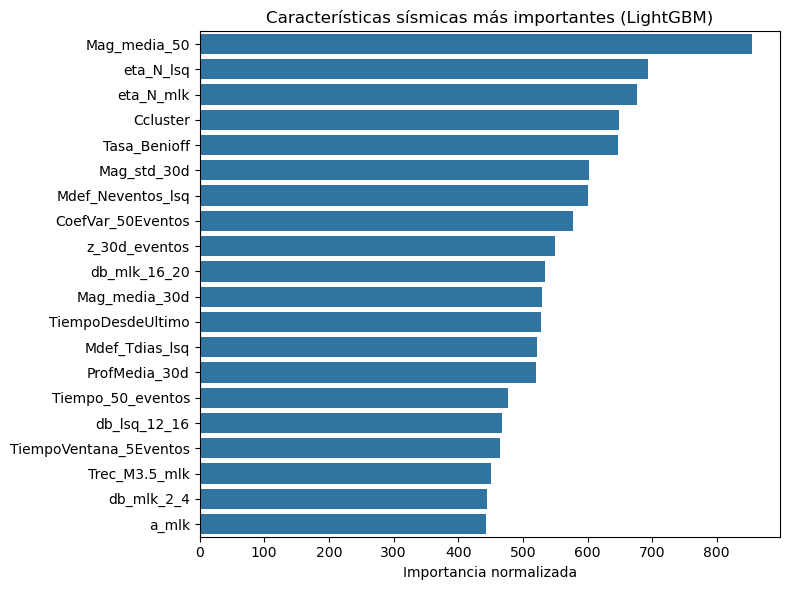

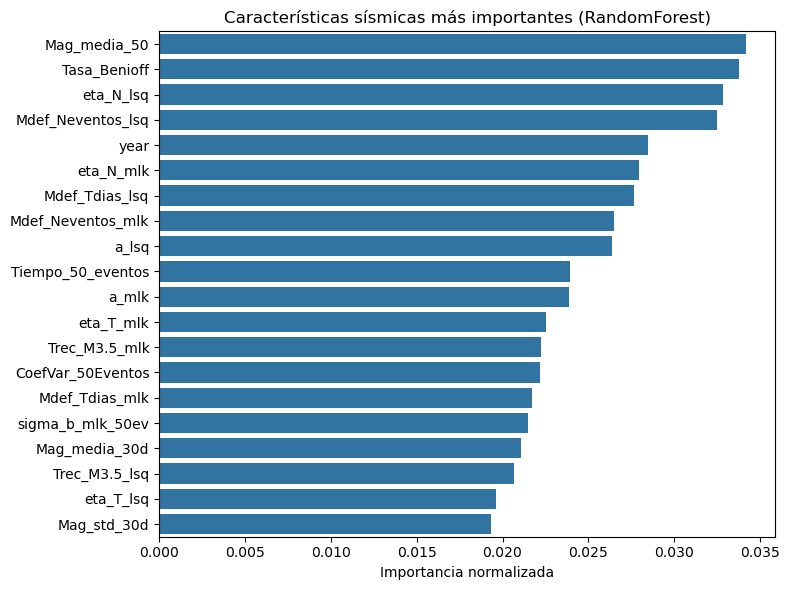


LightGBM - AP (PR-AUC) por clase:
  Clase 0: AP = 0.720
  Clase 1: AP = 0.790
  Clase 2: AP = 0.902
  Clase 3: AP = 0.942
  AP (macro) = 0.839

RandomForest - AP (PR-AUC) por clase:
  Clase 0: AP = 0.713
  Clase 1: AP = 0.797
  Clase 2: AP = 0.868
  Clase 3: AP = 0.930
  AP (macro) = 0.827


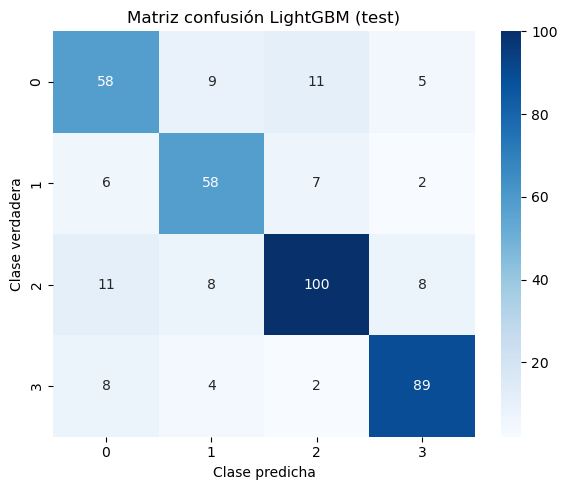

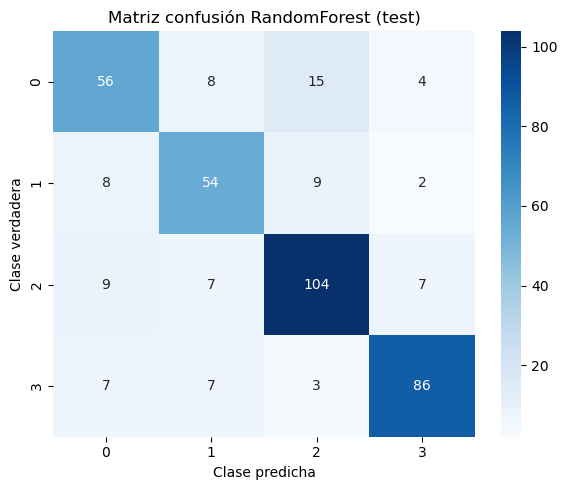


Reporte LightGBM (test):

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        83
           1       0.73      0.79      0.76        73
           2       0.83      0.79      0.81       127
           3       0.86      0.86      0.86       103

    accuracy                           0.79       386
   macro avg       0.78      0.79      0.78       386
weighted avg       0.79      0.79      0.79       386


Reporte RandomForest (test):

              precision    recall  f1-score   support

           0       0.70      0.67      0.69        83
           1       0.71      0.74      0.72        73
           2       0.79      0.82      0.81       127
           3       0.87      0.83      0.85       103

    accuracy                           0.78       386
   macro avg       0.77      0.77      0.77       386
weighted avg       0.78      0.78      0.78       386



In [18]:
# Comparación LightGBM vs RandomForest
# Requisitos: sklearn, lightgbm, matplotlib, pandas, numpy, seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, balanced_accuracy_score,
    average_precision_score, precision_recall_curve
)
import lightgbm as lgb

import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# ---------------------------
# Configurable: elige tu X e y
# ---------------------------
# Usa aquí el conjunto con el que quieras comparar: las 114 iniciales o las reducidas por LGBM/SHAP.
# Ejemplos (descomenta el que corresponda):
# X_train_all = X_train_embedded   # si X_train_embedded tiene las 114 features originales
# X_val_all   = X_val_embedded
# X_test_all  = X_test_embedded

# O si has reducido a 25/57:
X_train_all = X_train_embedded     # <-- sustituye si tu var se llama diferente
X_val_all   = X_val_embedded
X_test_all  = X_test_embedded

# y_train, y_val, y_test deben existir en el notebook
# Aseguramos arrays numpy
X_train_np = X_train_all.values if hasattr(X_train_all, "values") else np.asarray(X_train_all)
X_val_np   = X_val_all.values   if hasattr(X_val_all,   "values") else np.asarray(X_val_all)
X_test_np  = X_test_all.values  if hasattr(X_test_all,  "values") else np.asarray(X_test_all)

y_train_np = y_train.values if hasattr(y_train, "values") else np.asarray(y_train)
y_val_np   = y_val.values   if hasattr(y_val,   "values") else np.asarray(y_val)
y_test_np  = y_test.values  if hasattr(y_test,  "values") else np.asarray(y_test)

# Para CV combinamos train+val si quieres (opcional)
X_cv = np.vstack([X_train_np, X_val_np])   # opcional: entrenar CV en train+val
y_cv = np.hstack([y_train_np, y_val_np])

# ---------------------------
# Modelos base
# ---------------------------
lgb_clf = lgb.LGBMClassifier(n_estimators=300, random_state=42)
rf_clf  = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

# ---------------------------
# Funciones auxiliares
# ---------------------------
def compute_metrics(y_true, y_pred, labels=None):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }

def specificity_per_class(cm):
    # cm: confusion_matrix (rows true, cols pred)
    n_classes = cm.shape[0]
    spec = []
    for i in range(n_classes):
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        spec.append(tn / (tn + fp) if (tn+fp)>0 else 0.0)
    return np.array(spec)

# ---------------------------
# 1) Entrenar en train y validar en test (igual para ambos modelos)
# ---------------------------
results = {}
for name, clf in [("LightGBM", lgb_clf), ("RandomForest", rf_clf)]:
    clf.fit(X_train_np, y_train_np)
    y_pred = clf.predict(X_test_np)
    y_proba = clf.predict_proba(X_test_np) if hasattr(clf, "predict_proba") else None

    metrics = compute_metrics(y_test_np, y_pred)
    cm = confusion_matrix(y_test_np, y_pred)
    spec = specificity_per_class(cm)

    results[name] = {
        "clf": clf,
        "metrics": metrics,
        "cm": cm,
        "spec_per_class": spec,
        "y_proba": y_proba,
        "y_pred": y_pred
    }

# Mostrar resultados resumidos
df_compare = []
for name in results:
    m = results[name]["metrics"]
    df_compare.append({
        "Model": name,
        "Accuracy": m["accuracy"],
        "BalancedAcc": m["balanced_acc"],
        "F1_macro": m["f1_macro"],
        "F1_weighted": m["f1_weighted"]
    })
df_compare = pd.DataFrame(df_compare).set_index("Model")
print("\nComparación en Test (train en X_train):\n")
display(df_compare)

# ---------------------------
# 2) Cross-validation (en train+val)
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
cv_results = {}
for name, clf in [("LightGBM", lgb.LGBMClassifier(n_estimators=300, random_state=42)),
                  ("RandomForest", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))]:
    r = cross_validate(clf, X_cv, y_cv, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    cv_summary = {k: np.mean(r[k]) for k in r if k.startswith("test_")}
    cv_results[name] = cv_summary

print("\nResultados CV (train+val) promedio:\n")
display(pd.DataFrame(cv_results).T)

# ---------------------------
# 3) Importancias: top20 comparadas
# ---------------------------
def plot_feature_importances(clf, X_cols, topk=20, title=None,output_file=None):
    if hasattr(clf, "feature_importances_"):
        fi = clf.feature_importances_
    else:
        # si no hay, intentar permutation importance (no incluido aquí)
        raise ValueError("El clasificador no tiene attribute feature_importances_")
    idx = np.argsort(fi)[::-1][:topk]
    df = pd.DataFrame({"feature": np.array(X_cols)[idx], "importance": fi[idx]})
    fig=plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=df)
    plt.xlabel("Importancia normalizada")
    plt.ylabel("")
    plt.title(title or "Top features")
    plt.tight_layout()

    if output_file:
        fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
        fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)

    plt.show()
    
    return df

cols = X_train_all.columns if hasattr(X_train_all, "columns") else [f"f{i}" for i in range(X_train_np.shape[1])]

filename = f"Caracteristicas_importantes_LightGBM_RF_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

top_lgb = plot_feature_importances(results["LightGBM"]["clf"], cols, topk=20, 
            title="Características sísmicas más importantes (LightGBM)",output_file=output_file)

                                   
filename = f"Caracteristicas_importantes_RandomForest_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename
                                   
top_rf  = plot_feature_importances(results["RandomForest"]["clf"], cols, topk=20, 
            title="Características sísmicas más importantes (RandomForest)",output_file=output_file)



#plt.show()

# Guardar tablas si quieres
#top_lgb.to_csv("top20_lgb.csv", index=False)
#top_rf.to_csv("top20_rf.csv", index=False)

# ---------------------------
# 4) PR-AUC por clase (test)
# ---------------------------
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y_test_np))
y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))

for name in ["LightGBM", "RandomForest"]:
    clf = results[name]["clf"]
    if results[name]["y_proba"] is None:
        print(f"{name} no tiene predict_proba -> no calculo PR-AUC")
        continue
    proba = results[name]["y_proba"]
    # Asegurar shape (n_samples, n_classes)
    if proba.shape[1] != n_classes:
        print(f"{name}: número de clases en predict_proba != n_classes (saltando PR-AUC)")
        continue
    ap_per_class = []
    for i in range(n_classes):
        ap = average_precision_score(y_test_bin[:, i], proba[:, i])
        ap_per_class.append(ap)
    print(f"\n{name} - AP (PR-AUC) por clase:")
    for i, ap in enumerate(ap_per_class):
        print(f"  Clase {i}: AP = {ap:.3f}")
    print(f"  AP (macro) = {np.mean(ap_per_class):.3f}")

# ---------------------------
# 5) Matrices de confusión anotadas
# ---------------------------
def plot_cm(cm, labels, title,output_file=None):
    fig=plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase verdadera")
    plt.title(title)
    plt.tight_layout()

    if output_file:
        fig.savefig(f"{output_file}.pdf", bbox_inches='tight')
        fig.savefig(f"{output_file}.png", bbox_inches='tight', dpi=300)
        
    plt.show()

labels = np.unique(np.concatenate([y_train_np, y_val_np, y_test_np]))


filename = f"Matriz_confusion_LightGBM_RF_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

plot_cm(results["LightGBM"]["cm"], labels, "Matriz confusión LightGBM (test)",output_file=output_file)

filename = f"Matriz_confusion_RandomForest_{class_label}_zona_{zona}"
output_file=ruta+"/figuras/"+filename

plot_cm(results["RandomForest"]["cm"], labels,  "Matriz confusión RandomForest (test)",output_file=output_file)

# ---------------------------
# 6) Imprime detalle clasificación
# ---------------------------
print("\nReporte LightGBM (test):\n")
print(classification_report(y_test_np, results["LightGBM"]["y_pred"], zero_division=0))
print("\nReporte RandomForest (test):\n")
print(classification_report(y_test_np, results["RandomForest"]["y_pred"], zero_division=0))


In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    accuracy_score
)

def classification_report_with_specificity(y_true, y_pred, labels=None, target_names=None):
    """
    Genera un DataFrame estilo classification_report con columna extra 'specificity'
    """
    # Precision, recall, f1, support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    # Matriz de confusión para specificity
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i in range(len(labels)):
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        spec = tn / (tn + fp) if (tn+fp)>0 else 0.0
        specificity.append(spec)

    # DataFrame por clase
    report_df = pd.DataFrame({
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "support": support,
        "specificity": specificity
    }, index=target_names if target_names else labels)

    # Filas globales
    acc = accuracy_score(y_true, y_pred)
    macro_avg = report_df.iloc[:, :-1].mean(numeric_only=True)  # precision/recall/f1/support
    weighted_avg = (
        report_df[["precision","recall","f1-score"]].T.dot(support) / support.sum()
    )
    weighted_avg["support"] = support.sum()
    weighted_avg["specificity"] = np.average(specificity, weights=support)

    # Accuracy como fila separada
    report_df.loc["accuracy"] = [acc, acc, acc, acc, acc]

    # Añadir macro avg y weighted avg
    report_df.loc["macro avg"] = [
        macro_avg["precision"],
        macro_avg["recall"],
        macro_avg["f1-score"],
        support.sum(),
        np.mean(specificity)
    ]
    report_df.loc["weighted avg"] = [
        weighted_avg["precision"],
        weighted_avg["recall"],
        weighted_avg["f1-score"],
        weighted_avg["support"],
        weighted_avg["specificity"]
    ]

    return report_df

# ===========================
# USO con tus modelos en test
# ===========================
y_true = y_test_np

for name in ["LightGBM", "RandomForest"]:
    y_pred = results[name]["y_pred"]
    labels = np.unique(np.concatenate([y_train_np, y_val_np, y_test_np]))
    target_names = [str(l) for l in labels]

    report_df = classification_report_with_specificity(
        y_true, y_pred, labels=labels, target_names=target_names
    )
    print(f"\n===== Reporte con Specificity: {name} =====\n")
    display(report_df.round(6))



===== Reporte con Specificity: LightGBM =====



,precision,recall,f1-score,support,specificity
0,0.698795,0.698795,0.698795,83.000000,0.917492
1,0.734177,0.794521,0.763158,73.000000,0.932907
2,0.833333,0.787402,0.809717,127.000000,0.922780
3,0.855769,0.864078,0.859903,103.000000,0.946996
accuracy,0.790155,0.790155,0.790155,0.790155,0.790155
macro avg,0.780519,0.786199,0.782893,386.000000,0.930044
weighted avg,0.791639,0.790155,0.790452,386.000000,0.930020



===== Reporte con Specificity: RandomForest =====



,precision,recall,f1-score,support,specificity
0,0.700000,0.674699,0.687117,83.000000,0.920792
1,0.710526,0.739726,0.724832,73.000000,0.929712
2,0.793893,0.818898,0.806202,127.000000,0.895753
3,0.868687,0.834951,0.851485,103.000000,0.954064
accuracy,0.777202,0.777202,0.777202,0.777202,0.777202
macro avg,0.768277,0.767068,0.767409,386.000000,0.925080
weighted avg,0.777895,0.777202,0.777290,386.000000,0.923119
